### Otimização dos Dados

- Continuando a etapa anterior, agora vamos avaliar os erros cometidos pelos modelos, buscando insights que nos guiem para alterar ou complementar os dados.

- Para avaliar os erros, vamos utilizar, primeiramente, a **matriz de confusão** da classificação.

In [20]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
def get_data(train_path, test_path):
    train = pd.read_csv(train_path, header=0)
    test = pd.read_csv(test_path, header=0)
    data_train = train.to_numpy()
    n_row, n_col = data_train.shape
    X = data_train[:, 1:n_col]
    y = data_train[:,0]
    X_test = test.to_numpy()
    return X, y, X_test

def get_scale(train, test):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_test = scaler.transform(X_test)
    return X, X_test

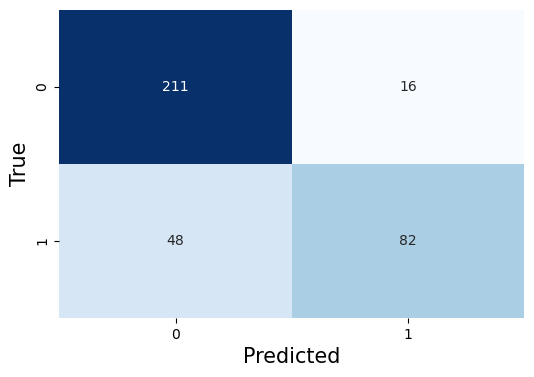

In [116]:
from sklearn.ensemble import RandomForestClassifier

X, y, X_test = get_data("dados/treino_tratado_2.csv", "dados/teste_tratado_2.csv")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=5)

rf = RandomForestClassifier(max_depth=9, min_samples_leaf=15, min_samples_split=20, random_state=42)

model_rf = rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_valid)

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("True", fontsize=15)
plt.show()

In [117]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87       227
         1.0       0.84      0.63      0.72       130

    accuracy                           0.82       357
   macro avg       0.83      0.78      0.79       357
weighted avg       0.82      0.82      0.81       357



- Notamos que o modelo está classificando muitos indivíduos que sobreviveram como óbitos, ou seja, há uma grande taxa de **Falsos Negativos**;

- **Hipóteses**: 

    - A primeira hipótese da causa desse fato é que o conjunto de dados esteja mais **desbalanceado** que o previsto no ínicio;
    - Outra hipótese seria que o modelo não esteja distinguindo corretamente a respeito da sobrevivência de homens ricos, dado que a maioria dos homens morreram;
    - A classificação da classe financeira dos passageiros pode estar errônea:
        - Ocorre que os portos de embarque eram distantes uns dos outros, ou seja, o passageiro que embarcou no porto mais longe pagou mais caro que o passageiro do porto mais próximo da chegada, independente da classe financeira.

- Para refutar as hipótese, vamos realizar uma análise exploratória nos dados Falsos Negativos.




In [118]:
Y_true = pd.DataFrame()
Y_pred = pd.DataFrame()

Y_true["True"] = y_valid
Y_pred["Predict"] = y_pred

Y_true = Y_true[Y_true["True"] == 1]
Y_pred = Y_pred[Y_pred["Predict"] == 0]

index_falneg = Y_true.index.intersection(Y_pred.index)
X_falneg = X_valid[index_falneg]


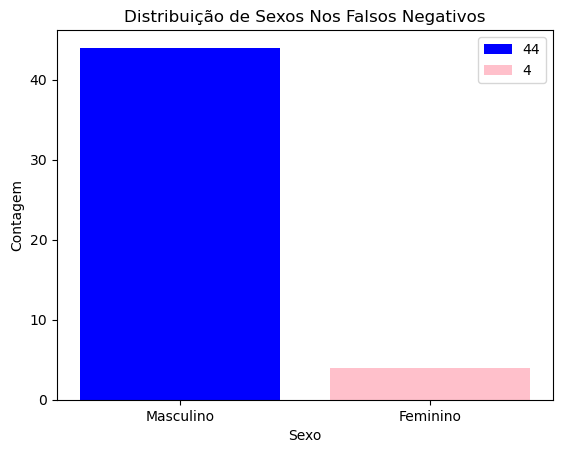

In [119]:
sex_data = X_falneg[:,4]

unique_sex, counts = np.unique(sex_data, return_counts=True)

plt.bar(unique_sex, counts, color=['blue', 'pink'], label=counts ) 
plt.xlabel('Sexo')
plt.ylabel('Contagem')
plt.title('Distribuição de Sexos Nos Falsos Negativos')
plt.xticks(unique_sex, ['Masculino', 'Feminino']) 
plt.legend()
plt.show()

In [121]:
class_1, counts_1 = np.unique(X_falneg[:,9], return_counts=True)
class_2, counts_2 = np.unique(X_falneg[:,10], return_counts=True)
class_3, counts_3 = np.unique(X_falneg[:,11], return_counts=True)

harbor_1, h_counts_1 = np.unique(X_falneg[:,6], return_counts=True)
harbor_2, h_counts_2 = np.unique(X_falneg[:,7], return_counts=True)
harbor_3, h_counts_3 = np.unique(X_falneg[:,8], return_counts=True)

unique_class = ["Classe_1", 'Classe_2', "Classe_3"]
counts_class = [counts_1[1], counts_2[1], counts_3[1]]
print(h_counts_2)
# unique_harbor = ["Harbor_S", 'Harbor_C', "Harbor_Q"]
# counts_harbor = [h_counts_1[1], h_counts_2[1], h_counts_3[1]]

# plt.bar(unique_class, counts_class, label=counts_class, color=["black", 'red', "blue"] ) 
# plt.xlabel('Classes')
# plt.ylabel('Contagem')
# plt.title('Distribuição das Classes nos Falsos Negativos')
# plt.xticks(unique_class, ["Classe_1", 'Classe_2', "Classe_3"]) 
# plt.legend()
# plt.show()



[47  1]


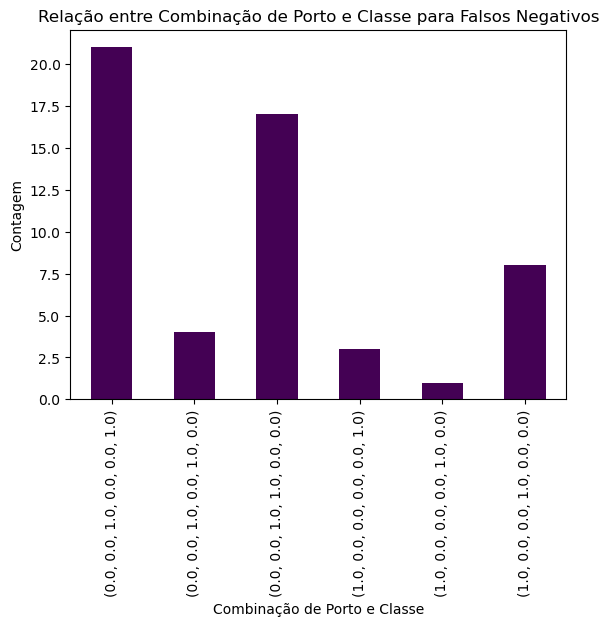

In [105]:
data = {'Porto_S': X_falneg[:, 6], 'Porto_C': X_falneg[:, 7], 'Porto_Q': X_falneg[:, 8], 'Classe_1': X_falneg[:, 9], 
        'Classe_2': X_falneg[:, 10], 'Classe_3': X_falneg[:, 11]}
df = pd.DataFrame(data) 

counts = df.groupby(['Porto_S', 'Porto_C', 'Porto_Q', 'Classe_1', "Classe_2", 'Classe_3']).size()
ax = counts.plot(kind='bar', stacked=True, colormap='viridis')

# Adicionar rótulos ao gráfico
plt.xlabel('Combinação de Porto e Classe')
plt.ylabel('Contagem')
plt.title('Relação entre Combinação de Porto e Classe para Falsos Negativos')

# Mostrar o gráfico
plt.show()


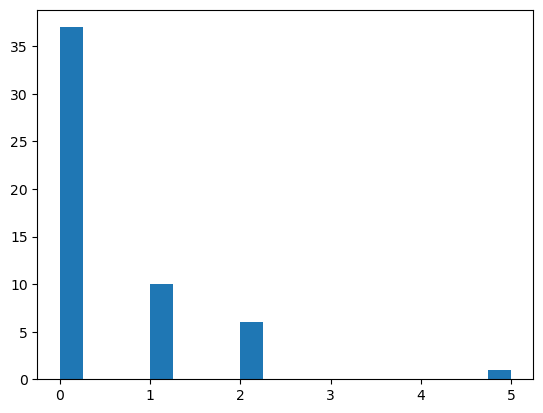

In [90]:
plt.hist(X_falneg[:,2], bins=20)
plt.show()